# One-Layer Networks on CIFAR10

## Contents

* [Introduction](#introduction)
* [Imports](#imports)
* [Import Datasets](#import-datasets)
* [Data Pre-Processing](#data-pre-processing)
* [Numerical Gradient Check](#numerical-gradient-check)
* [Training and Results](#training-and-results)
    - [One-Layer Network with SVM Classifier](#one-layer-network-with-svm-classifier)
    - [One-Layer Network with Softmax Classifier](#one-layer-network-with-softmax-classifier)
* [Playing with Hyperparameters](#playing-with-hyperparameters)

## Introduction <a class="anchor" id="introduction"></a>

In this notebook, a one-layer network with multiple outputs is trained and tested to classify images from the CIFAR-10 dataset. The network is trained using mini-batch gradient descent applied to a cost function that computes the either the Hinge or the cross-entropy loss of the classifier applied to the labelled training data and an L2 regularization term on the weight matrix. Then, the effect of changing the learning rate and the regularization strength on the network performance are explored.

In my implementation, I aimed at general code that can be used in later assignments to build deeper networks. As a result, I implemented the ```Dense``` layer (fully-connected layer) that can have activations such as ```LinearActivation```, ```ReLUActivation```, or ```SoftmaxActivation```. The learnable (or trainable) weights of the ```Dense``` layer can be initialized with the ```NormalInitializer``` class, and can be regularized with the ```L2Regularizer```. Furthermore, I implemeted the ```CategoricalCrossEntropyLoss``` class that can be combined with a ```Dense``` layer with a  ```SoftmaxActivation``` to yield the multi-class linear classifier, which was the task to implement. Using the ```SGDOptimizer``` with the ```LRConstantSchedule``` constant learning rate schedule (i.e.: learning rate is constant over epochs), the one-layer linear multi-class classifier can be trained with backpropagation. The forward and backpropagation across layers (here just one layer) are implemented within the ```Model``` class. Similarly to Keras, the ```Model``` is first compiled with the optimizer, the loss, and some metrics such as the ```AccuracyMetrics``` class, and then trained using the ```Model.fit``` method.

## Imports <a class="anchor" id="imports"></a>

Import the library parts and the required packages.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, ceil
import pandas as pd

from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalHingeLoss, CategoricalCrossEntropyLoss, LossSmootherConstant
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer
from layers import Dense
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics
from lr_schedules import LRConstantSchedule
from optimizers import SGDOptimizer
from opt_utils import GradClipperByNothing
from viz_utils import plot_losses, plot_costs, plot_accuracies, plot_lrs
from grad_check import numerical_gradient_check_model

## Import Datasets <a class="anchor" id="import-datasets"></a>

In this notebook, for the sake of speed, the training set is ```data_batch_1```, the validation set is ```data_batch_2```, and the test set is ```test_batch```.

In [2]:
# train set is batch 1, val set is batch 2, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

print(f"There are {np.unique(y_train).size} labels which are: \n{np.unique(y_train)}")

There are 10 labels which are: 
[0 1 2 3 4 5 6 7 8 9]


Check set shapes and if the dataset split across training, validation, and test is balanced.

In [3]:
# check counts in datasets
print(f"The images are of shape: {x_train_img.shape[1:]}")
print(f"The set sizes are train: {x_train_img.shape[0]}, "
      f"validation: {x_val_img.shape[0]}, and test: {x_test_img.shape[0]}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# This is approximating the ratios, good enough
np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

print(f"The class ratios in the training set are: {train_ratios}")
print(f"The class ratios in the validation set are: {val_ratios}")
print(f"The class ratios in the test set are: {test_ratios}")

The images are of shape: (32, 32, 3)
The set sizes are train: 10000, validation: 10000, and test: 10000
The class ratios in the training set are: [0.1005 0.0974 0.1032 0.1016 0.0999 0.0937 0.103  0.1001 0.1025 0.0981]
The class ratios in the validation set are: [0.0984 0.1007 0.101  0.0995 0.101  0.0988 0.1008 0.1026 0.0987 0.0985]
The class ratios in the test set are: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


Let's visualize some random images in the dataset.

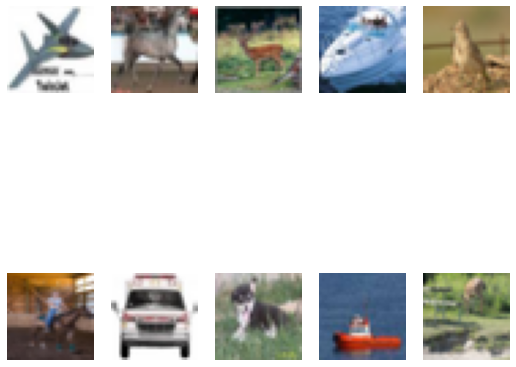

In [4]:
# show some random pics
show_n = 10
assert show_n % 2 == 0, f"{show_n} needs to be an even number"
np.random.seed(100)
show_indices = np.random.choice(x_train_img.shape[0], show_n, replace=False)

x_train_img_show = x_train_img[show_indices]

fig, axs = plt.subplots(2, show_n // 2,figsize=(9,9))

for idx, img in enumerate(x_train_img_show):
    row_idx = 1 - int(idx % 2 == 0)
    ax = axs[row_idx, idx // 2]
    ax.imshow(img)
    ax.axis('off')

plt.show()

## Data Pre-Processing <a class="anchor" id="data-pre-processing"></a>

Pre-process datasets by standardization of features (subtract mean of each feature and divide by its standard deviation). Use the training mean and standard deviation on the validation and the test datasets! After this, the mean of each feature in the subsets should be around 0 and the standard deviation should be around 1.

In [5]:
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

mean = np.mean(x_train_un, axis=0).reshape(1, x_train_un.shape[1])
std = np.std(x_train_un, axis=0).reshape(1, x_train_un.shape[1])

x_train = (x_train_un - mean) / std
x_val = (x_val_un - mean) / std
x_test = (x_test_un - mean) / std

print(f"The means of the training set: {np.mean(x_train, axis=0)} "
      f"(#features = {np.mean(x_train, axis=0).size})")
print(f"The stds of the training set: {np.std(x_train, axis=0)} "
      f"(#features = {np.mean(x_train, axis=0).size})")

print(f"The means of the validation set: {np.mean(x_val, axis=0)}")
print(f"The stds of the validation set: {np.std(x_val, axis=0)}")

print(f"The means of the test set: {np.mean(x_test, axis=0)}")
print(f"The stds of the test set: {np.std(x_test, axis=0)}")

The means of the training set: [ 1.31672451e-16  5.32907052e-18  3.59934305e-17 ... -1.10966791e-16
 -1.01096909e-16  2.62401212e-17] (#features = 3072)
The stds of the training set: [1. 1. 1. ... 1. 1. 1.] (#features = 3072)
The means of the validation set: [-0.02151247 -0.01731957 -0.01718778 ... -0.00928345 -0.00494739
 -0.00583879]
The stds of the validation set: [0.9972366  0.99489016 0.99599598 ... 0.99822343 0.98979069 0.99003225]
The means of the test set: [-0.01997713 -0.01194233 -0.00644388 ... -0.01584402 -0.00696293
  0.00331293]
The stds of the test set: [0.99457784 0.98900477 0.98955298 ... 0.98649573 0.97809437 0.98249776]


## Numerical Gradient Check <a class="anchor" id="numerical-gradient-check"></a>

The correctness of the gradient computation and backpropagation was assured via numerical gradient check. I implemented the double centered gradient check with the ```numerical_gradient_check_model``` that computes the analytical and numerical gradients, and then compares them in each layer in the model. As outlined in [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-3/#gradcheck), it is satisfactory to assert that the analytical gradients of the model are correct based on the values shwon below . To avoid kinks in the objective function, only a few data points were used in the gradient check. The step size for computing the numerical gradient was set to 1e-06. In computing the relative error, the formula provided in [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-3/#gradcheck) was used. Furthermore, the ```numpy.testing.assert\_array\_almost\_equal``` function was also used to make the comparison.

In [6]:
def build_model_svm(reg_rate_l2, in_dim, out_dim, seed):
    
    # kernel and bias initializer params, normal distribution
    init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}

    # define the dense layer
    dense_1 = \
        Dense(in_dim=in_dim, out_dim=out_dim, 
              kernel_initializer=NormalInitializer(seed=None, **init_params), 
              bias_initializer=NormalInitializer(seed=None, **init_params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=LinearActivation()
             )

    # define the list of layers
    layers = [
        dense_1
    ]

    # define the model
    model = Model(layers)

    # define the loss
    loss = CategoricalHingeLoss(loss_smoother=LossSmootherConstant())
    
    return model, loss

def build_model_softmax(reg_rate_l2, in_dim, out_dim, seed):
    
    # kernel and bias initializer params, normal distribution
    init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}

    # define the dense layer
    dense_1 = \
        Dense(in_dim=in_dim, out_dim=out_dim, 
              kernel_initializer=NormalInitializer(seed=None, **init_params), 
              bias_initializer=NormalInitializer(seed=None, **init_params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=LinearActivation()
             )

    # define the list of layers
    layers = [
        dense_1
    ]

    # define the model
    model = Model(layers)

    # define the loss
    loss = CategoricalHingeLoss(loss_smoother=LossSmootherConstant())
    
    return model, loss


def test_model(x, y, seed=6):
    in_dim = x.shape[1]
    out_dim = np.unique(y_train).size

    build_model_loss_func_dict = {
        "svm": build_model_svm,
        "softmax": build_model_softmax
    }

    np.random.seed(seed + 3)
    reg_rates = 10e-2 * np.random.randint(low=1, high=10, size=5)

    for reg_rate in reg_rates:
        for key, build_model_func in build_model_loss_func_dict.items():
            print(f"network with {key} classifier, reg. rate = {reg_rate:.4f}")
            model, loss = build_model_func(reg_rate, in_dim, out_dim, seed)
            numerical_gradient_check_model(x, y, model, loss)
            print()
            
test_model(x_train[:2, :10], y_train[:2])

network with svm classifier, reg. rate = 0.6000
layer=0, param_name=w
max rel error=8.102111212076678e-10
layer=0, param_name=b
max rel error=5.096012495515732e-11
test_grad_check passed

network with softmax classifier, reg. rate = 0.6000
layer=0, param_name=w
max rel error=1.1418200919180561e-09
layer=0, param_name=b
max rel error=1.3977796681941104e-10
test_grad_check passed

network with svm classifier, reg. rate = 0.7000
layer=0, param_name=w
max rel error=7.889198782620107e-10
layer=0, param_name=b
max rel error=5.096012495515732e-11
test_grad_check passed

network with softmax classifier, reg. rate = 0.7000
layer=0, param_name=w
max rel error=6.45864300242432e-10
layer=0, param_name=b
max rel error=5.096012495515732e-11
test_grad_check passed

network with svm classifier, reg. rate = 0.9000
layer=0, param_name=w
max rel error=5.989978578958375e-10
layer=0, param_name=b
max rel error=5.096012495515732e-11
test_grad_check passed

network with softmax classifier, reg. rate = 0.9000

## Training and Results <a class="anchor" id="training-and-results"></a>

Let's try using two different type of classifiers - SVM and Softmax - in the last layers (and therefore two different cost function). Also, different values of the L2 regularization strength and the learning rate will be explored, hovever, here not through hyperparameter search (see another noteebok).

The results of the training are saved at ```assets/one_layer/``` in corresponding subdirectories.

### One-Layer Network with SVM Classifier <a class="anchor" id="one-layer-network-with-svm-classifier"></a>

Firstly, a SVM classfier with the Hinge loss is trained.

In [7]:
# kernel and bias initializer params, normal distribution
init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}

# input and output dimensions
in_dim = x_train.shape[1]
out_dim = np.unique(y_train).size

# L2 regularization rate
reg_rate_l2 = 1.0

# define the dense layer
dense_1 = \
    Dense(in_dim=in_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **init_params), 
          bias_initializer=NormalInitializer(seed=None, **init_params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=LinearActivation()
         )

# define the list of layers
layers = [
    dense_1
]

# define the model
model = Model(layers)

# define the loss
loss = CategoricalHingeLoss(loss_smoother=LossSmootherConstant())

# define the SGD optimizer with constant learning rate schedule (i.e: constant lr)
lr_initial = 0.0001
optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial), 
                         grad_clipper=GradClipperByNothing())

# define the number of epochs and the mini-batch size
n_epochs = 40
batch_size = 100

# define the metrics of interest
metrics = [AccuracyMetrics()]

# compile and fit the model with the optimizer, the loss, and the metrics
model.compile_model(optimizer, loss, metrics)
print(model)
# verbosity level of fit
verbose = 2
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose, aug_func=None)

model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2), reg: l2 with 1.0000e+00
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 activation: linear

categorical hinge loss with loss smoother constant
sgd with constant lr schedule and clipper who does nothing

starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 192.35it/s]
epoch 1/40 
 	 -- train loss = 5.845381817531972 / train cost = 7.363384170904432
	 -- {"accuracy_train": 0.2806} 
	 -- val loss = 6.067617786311781 / val cost = 7.5856201396842415
	 -- {"accuracy_val": 0.2691} 


starting epoch: 2 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 220.75it/s]
epoch 2/40 
 	 -- train loss = 5.314275536368175 / train cost = 6.805704188163278
	 -- {"accuracy_train": 0.317} 
	 -- val loss = 5.617945003241808 / val cost = 7.1093736550369115
	 -- {"accuracy_val": 0.3003} 


starting epoch: 3 ...
batch 100/100: 100%|██████████| 100/100 [

batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 202.42it/s]
epoch 27/40 
 	 -- train loss = 4.068882276488978 / train cost = 5.0611135339381805
	 -- {"accuracy_train": 0.4116} 
	 -- val loss = 4.762723280088778 / val cost = 5.754954537537981
	 -- {"accuracy_val": 0.3668} 


starting epoch: 28 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 202.79it/s]
epoch 28/40 
 	 -- train loss = 4.053790026068168 / train cost = 5.031419230172873
	 -- {"accuracy_train": 0.415} 
	 -- val loss = 4.751385569467267 / val cost = 5.729014773571972
	 -- {"accuracy_val": 0.3694} 


starting epoch: 29 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 206.85it/s]
epoch 29/40 
 	 -- train loss = 4.043983620496618 / train cost = 5.0074126471684055
	 -- {"accuracy_train": 0.415} 
	 -- val loss = 4.748116177890549 / val cost = 5.711545204562336
	 -- {"accuracy_val": 0.3672} 


starting epoch: 30 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 187.28it/s]
epoch 30/40 
 	 -- train 

As results, the cost, loss and accuracy curves on the training and the validation datasets are shown, and then the model accuracy on the test set is considered. Furthermore, the learned weights in the single-layer neural network are visualized.

The cost, loss, and accuracy curves on the training and the validation datasets are shown below.

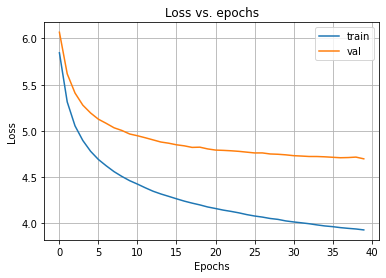

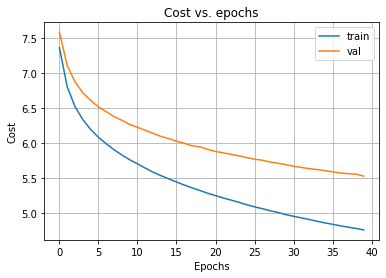

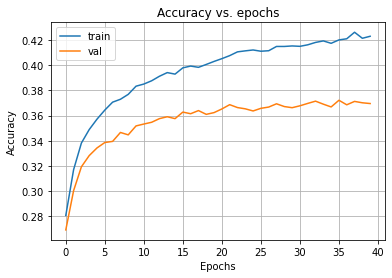

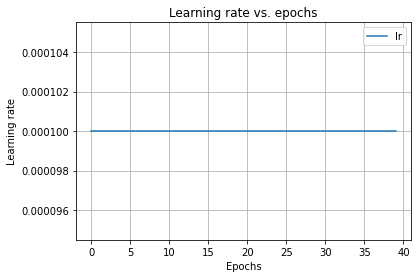

In [8]:
path_save_losses = "assets/one_layer/hinge/losses.png"
path_save_costs = "assets/one_layer/hinge/costs.png"
path_save_accuracies = "assets/one_layer/hinge/accuracies.png"
path_save_lrs = "assets/one_layer/hinge/lrs.png"
plot_losses(history, path_save_losses)
plot_costs(history, path_save_costs)
plot_accuracies(history, path_save_accuracies)
plot_lrs(history, path_save_lrs)

The accuracy on the test set is shown below.

In [9]:
params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

print(f"The test metrics are: {metrics_test}")

The test metrics are: {'accuracy': 0.3703}


The learned weights in the single-layer network are shown below.

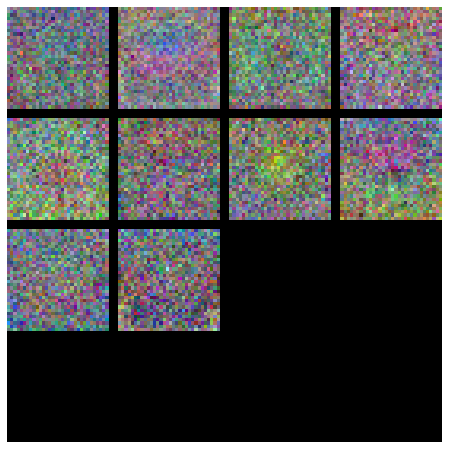

In [10]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    The function is taken from: https://cs231n.github.io/
    Reshape a 4D tensor of image data to a grid for easy visualization.
    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid


def viz_kernel(w, im_shape, figsize, save_path=None):
    w = w.reshape(im_shape + (-1,)).transpose(3, 0, 1, 2)
    plt.figure(figsize=figsize)
    plt.imshow(visualize_grid(w, padding=3).astype('uint8'))
    plt.gca().axis('off')
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

w = model.get_trainable_params()[-1]["w"]
im_shape=(32,32,3)
figsize=(8,8)
save_path = "assets/one_layer/hinge/learned_weights.png"
viz_kernel(w, im_shape, figsize, save_path)

### One-Layer Network with Softmax Classifier <a class="anchor" id="one-layer-network-with-softmax-classifier"></a>

Secondly, a Softmax classfier with the categorical cross-entropy loss is trained.

model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2), reg: l2 with 1.0000e+00
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 activation: softmax

categorical cross-entropy loss with loss smoother constant
sgd with constant lr schedule and clipper who does nothing

starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 223.93it/s]
epoch 1/40 
 	 -- train loss = 2.261176996093669 / train cost = 3.7669733424927156
	 -- {"accuracy_train": 0.162} 
	 -- val loss = 2.270566463376779 / val cost = 3.7763628097758253
	 -- {"accuracy_val": 0.1589} 


starting epoch: 2 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 215.58it/s]
epoch 2/40 
 	 -- train loss = 2.17543496396805 / train cost = 3.6510170789991814
	 -- {"accuracy_train": 0.2116} 
	 -- val loss = 2.1910777239098542 / val cost = 3.6666598389409857
	 -- {"accuracy_val": 0.2012} 


starting epoch: 3 ...
batch 100/100: 100%|██████████

batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 179.44it/s]
epoch 27/40 
 	 -- train loss = 1.8578361299670105 / train cost = 2.773646533960177
	 -- {"accuracy_train": 0.3624} 
	 -- val loss = 1.905835079923547 / val cost = 2.821645483916713
	 -- {"accuracy_val": 0.3405} 


starting epoch: 28 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 197.67it/s]
epoch 28/40 
 	 -- train loss = 1.8544756469606503 / train cost = 2.75345676596735
	 -- {"accuracy_train": 0.3641} 
	 -- val loss = 1.9030886394309152 / val cost = 2.8020697584376153
	 -- {"accuracy_val": 0.3418} 


starting epoch: 29 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 199.78it/s]
epoch 29/40 
 	 -- train loss = 1.851267882244102 / train cost = 2.733768319665923
	 -- {"accuracy_train": 0.3658} 
	 -- val loss = 1.9004922030516915 / val cost = 2.7829926404735126
	 -- {"accuracy_val": 0.3431} 


starting epoch: 30 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 196.38it/s]
epoch 30/40 
 	 -- t

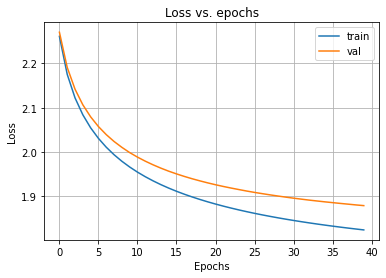

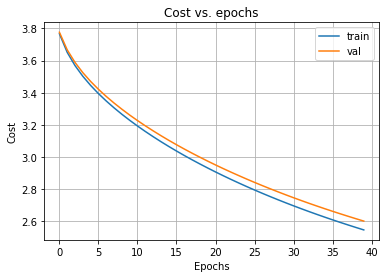

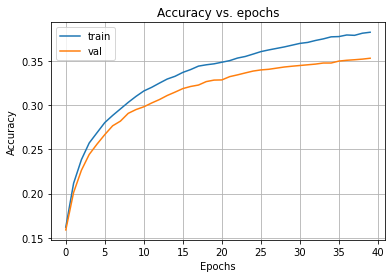

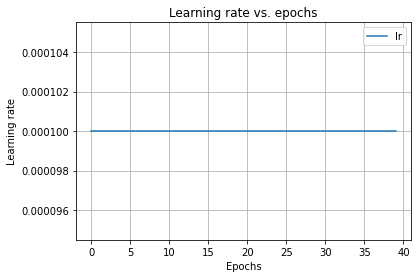

The test metrics are: {'accuracy': 0.3615}


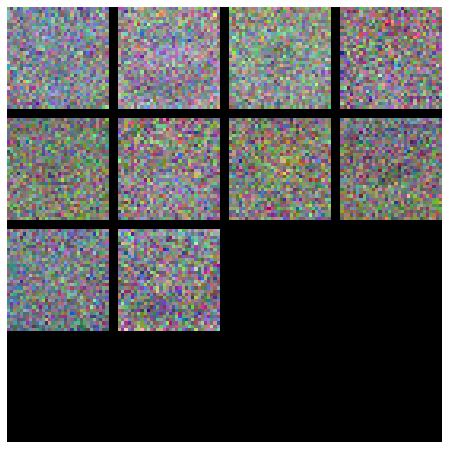

In [11]:
# kernel and bias initializer params, normal distribution
init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}

# input and output dimensions
in_dim = x_train.shape[1]
out_dim = np.unique(y_train).size

# L2 regularization rate
reg_rate_l2 = 1.0

# define the dense layer
dense_1 = \
    Dense(in_dim=in_dim, out_dim=out_dim, 
          kernel_initializer=NormalInitializer(seed=None, **init_params), 
          bias_initializer=NormalInitializer(seed=None, **init_params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

# define the list of layers
layers = [
    dense_1
]

# define the model
model = Model(layers)

# define the loss
loss = CategoricalCrossEntropyLoss(loss_smoother=LossSmootherConstant())

# define the SGD optimizer with constant learning rate schedule (i.e: constant lr)
lr_initial = 0.0001
optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial), 
                         grad_clipper=GradClipperByNothing())

# define the number of epochs and the mini-batch size
n_epochs = 40
batch_size = 100

# define the metrics of interest
metrics = [AccuracyMetrics()]

# compile and fit the model with the optimizer, the loss, and the metrics
model.compile_model(optimizer, loss, metrics)
print(model)
# verbosity level of fit
verbose = 2
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose, aug_func=None)

path_save_losses = "assets/one_layer/cross_entropy/losses.png"
path_save_costs = "assets/one_layer/cross_entropy/costs.png"
path_save_accuracies = "assets/one_layer/cross_entropy/accuracies.png"
path_save_lrs = "assets/one_layer/cross_entropy/lrs.png"
plot_losses(history, path_save_losses)
plot_costs(history, path_save_costs)
plot_accuracies(history, path_save_accuracies)
plot_lrs(history, path_save_lrs)

params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

print(f"The test metrics are: {metrics_test}")

w = model.get_trainable_params()[-1]["w"]
im_shape=(32,32,3)
figsize=(8,8)
save_path = "assets/one_layer/cross_entropy/learned_weights.png"
viz_kernel(w, im_shape, figsize, save_path)

The generalization capability and the test performance of the networks with the SVM and the Softmax classfiers seem to be on par. It is likely due to the fact that, here, only a subset of the full CIFAR-10 dataset is used. Both networks could be trained further. 

## Playing with Hyperparameters <a class="anchor" id="playing-with-hyperparameters"></a>

In this notebook, no methodological hyperparameter search is conducted, the aim here merely is to show how the networks' performance change with changes in the learning rate and the L2 regularization strength. Also, it is seeked what combination yields more characterisitc learned weight visualizations. For the experiments, the network with the Softmax classfier is used. The number of epochs and the mini-batch size are as before, and all of the learnable parameters are initialized with values drawn from N(0,0.01)

To that end, the following hyperparameter combination are explored:

| reg_rate_l2      | lr |
| ----------- | ----------- |
| 0.0      | 0.1       |
| 0.0   | 0.001        |
| 0.1   | 0.001        |
| 1.0   | 0.001        |

In [12]:
def run_experiment(verbose=0, **kwargs):
    reg_rate_l2 = kwargs["reg_rate_l2"]
    lr_initial = kwargs["lr_initial"]
    
    # kernel and bias initializer params, normal distribution
    init_params = {"coeff": 1.0, "mean": 0.0, "std": 0.01}

    # input and output dimensions
    in_dim = x_train.shape[1]
    out_dim = np.unique(y_train).size

    # define the dense layer
    dense_1 = \
        Dense(in_dim=in_dim, out_dim=out_dim, 
              kernel_initializer=NormalInitializer(seed=None, **init_params), 
              bias_initializer=NormalInitializer(seed=None, **init_params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=SoftmaxActivation()
             )

    # define the list of layers
    layers = [
        dense_1
    ]

    # define the model
    model = Model(layers)

    # define the loss
    loss = CategoricalCrossEntropyLoss(loss_smoother=LossSmootherConstant())

    # define the SGD optimizer with constant learning rate schedule (i.e: constant lr)
    optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial), 
                             grad_clipper=GradClipperByNothing())

    # define the number of epochs and the mini-batch size
    n_epochs = 40
    batch_size = 100

    # define the metrics of interest
    metrics = [AccuracyMetrics()]

    # compile and fit the model with the optimizer, the loss, and the metrics
    model.compile_model(optimizer, loss, metrics)
    print(model)
    
    history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose, aug_func=None)

    path_save_losses = f"assets/one_layer/cross_entropy/lr_{lr_initial}_reg_rate_l2_{reg_rate_l2}_losses.png"
    path_save_costs = f"assets/one_layer/cross_entropy/lr_{lr_initial}_reg_rate_l2_{reg_rate_l2}_costs.png"
    path_save_accuracies = f"assets/one_layer/cross_entropy/lr_{lr_initial}_reg_rate_l2_{reg_rate_l2}_accuracies.png"
    path_save_lrs = f"assets/one_layer/cross_entropy/lr_{lr_initial}_reg_rate_l2_{reg_rate_l2}_lrs.png"
    plot_losses(history, path_save_losses)
    plot_costs(history, path_save_costs)
    plot_accuracies(history, path_save_accuracies)
    plot_lrs(history, path_save_lrs)

    params_test = {"mode": "test"}
    scores_test = model.forward(x_test, **params_test)
    y_hat_test = np.argmax(scores_test, axis=1)
    metrics_test = model.compute_metrics(y_test, scores_test)
    kwargs["metrics_test"] = metrics_test

    print(f"The test metrics are: {metrics_test}")

    w = model.get_trainable_params()[-1]["w"]
    im_shape=(32,32,3)
    figsize=(8,8)
    save_path = f"assets/one_layer/cross_entropy/lr_{lr_initial}_reg_rate_l2_{reg_rate_l2}_learned_weights.png"
    viz_kernel(w, im_shape, figsize, save_path)
    
    return kwargs

model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2), reg: l2 with 0.0000e+00
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 activation: softmax

categorical cross-entropy loss with loss smoother constant
sgd with constant lr schedule and clipper who does nothing



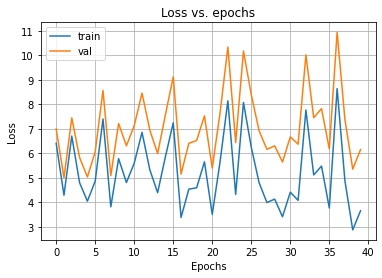

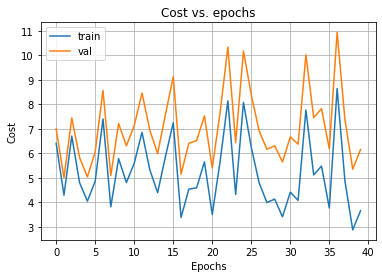

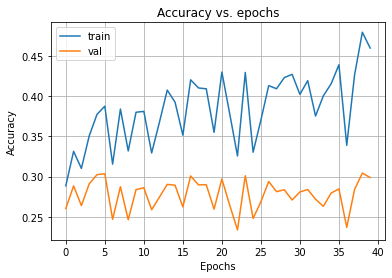

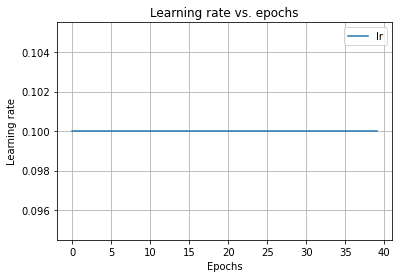

The test metrics are: {'accuracy': 0.2999}


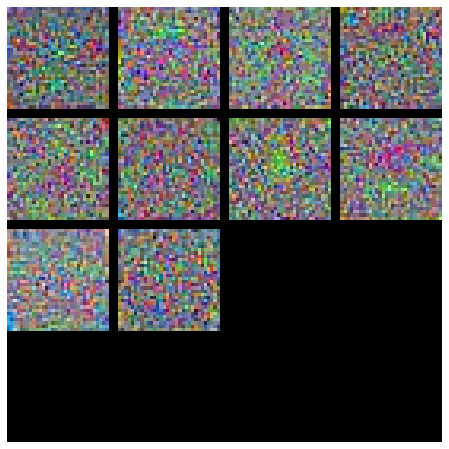

experiment idx=0: {'reg_rate_l2': 0.0, 'lr_initial': 0.1, 'metrics_test': {'accuracy': 0.2999}}

model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2), reg: l2 with 0.0000e+00
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 activation: softmax

categorical cross-entropy loss with loss smoother constant
sgd with constant lr schedule and clipper who does nothing



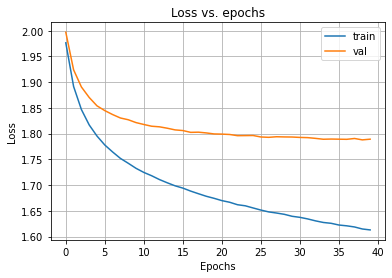

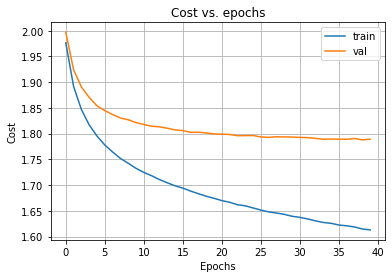

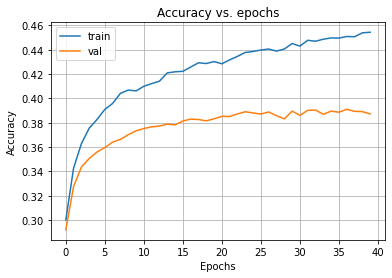

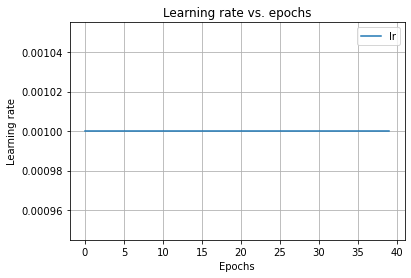

The test metrics are: {'accuracy': 0.39}


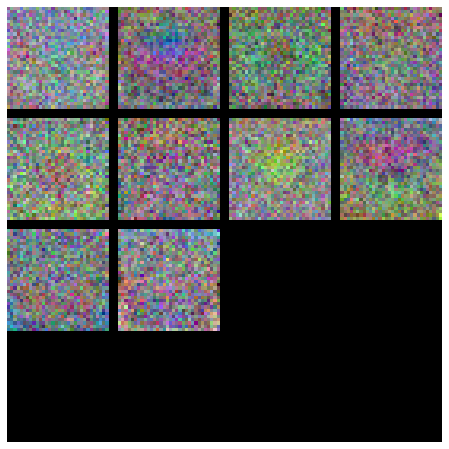

experiment idx=1: {'reg_rate_l2': 0.0, 'lr_initial': 0.001, 'metrics_test': {'accuracy': 0.39}}

model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2), reg: l2 with 1.0000e-01
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 activation: softmax

categorical cross-entropy loss with loss smoother constant
sgd with constant lr schedule and clipper who does nothing



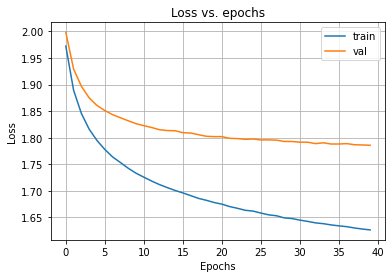

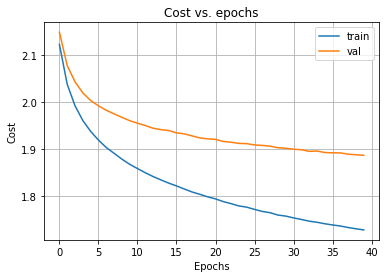

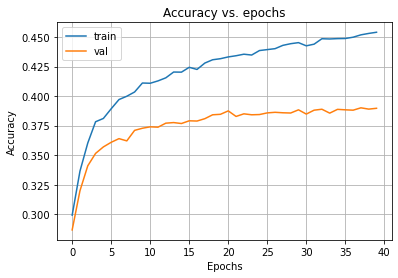

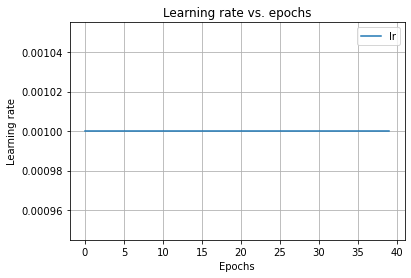

The test metrics are: {'accuracy': 0.397}


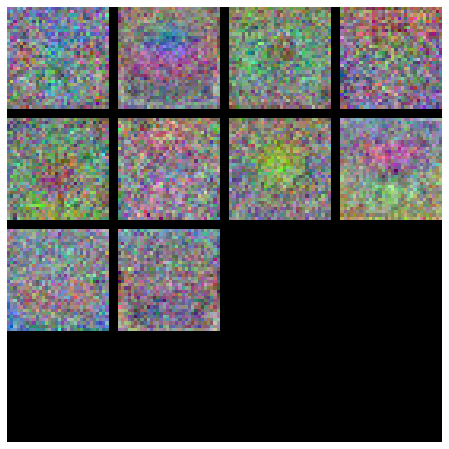

experiment idx=2: {'reg_rate_l2': 0.1, 'lr_initial': 0.001, 'metrics_test': {'accuracy': 0.397}}

model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 10
	 w -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2), reg: l2 with 1.0000e+00
	 b -- init: normal ~ 1.000000 x N(0.000000, 0.010000^2)
	 activation: softmax

categorical cross-entropy loss with loss smoother constant
sgd with constant lr schedule and clipper who does nothing



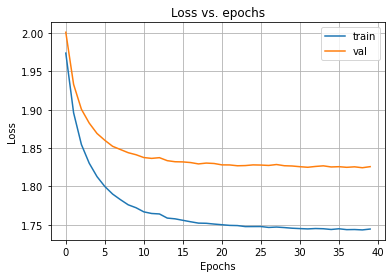

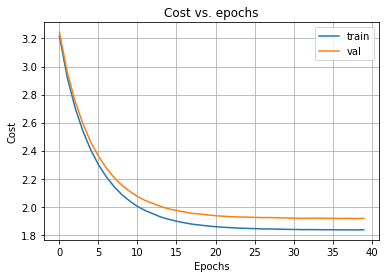

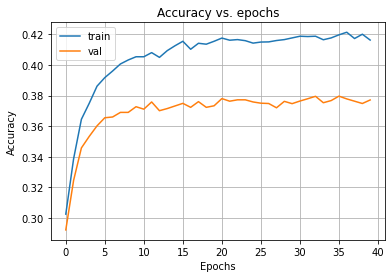

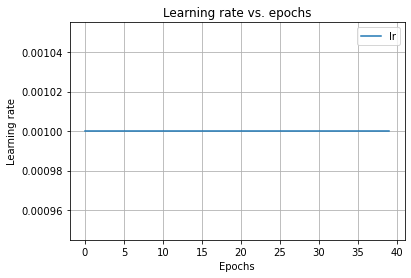

The test metrics are: {'accuracy': 0.3822}


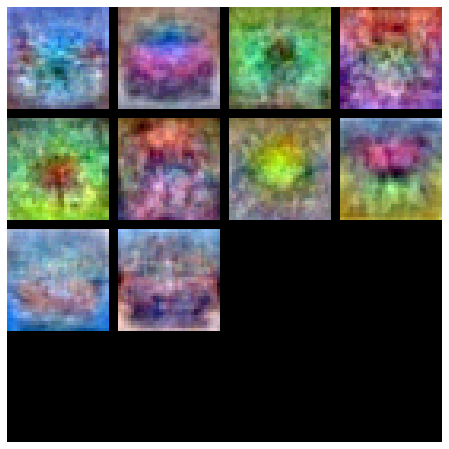

experiment idx=3: {'reg_rate_l2': 1.0, 'lr_initial': 0.001, 'metrics_test': {'accuracy': 0.3822}}



In [13]:
experiments = [
    {"reg_rate_l2": 0.0, "lr_initial": 0.1, "metrics_test": None},
    {"reg_rate_l2": 0.0, "lr_initial": 0.001, "metrics_test": None},
    {"reg_rate_l2": 0.1, "lr_initial": 0.001, "metrics_test": None},
    {"reg_rate_l2": 1.0, "lr_initial": 0.001, "metrics_test": None}
]

for idx, experiment in enumerate(experiments):
    experiment = run_experiment(verbose=0, **experiment)
    print(f"experiment idx={idx}: {experiment}\n")
    experiments[idx] = experiment

In [14]:
df = pd.DataFrame(data=experiments)
print(df)

   reg_rate_l2  lr_initial          metrics_test
0          0.0       0.100  {'accuracy': 0.2999}
1          0.0       0.001    {'accuracy': 0.39}
2          0.1       0.001   {'accuracy': 0.397}
3          1.0       0.001  {'accuracy': 0.3822}


As shown by the results, the learning rate of 0.1 without any L2 regularization results in an oscillating loss that hardly decreases.  In this case, the learning rate is too big and the mini-batch gradient descent causes too big step sizes in the learnable parameter updates,  which  in  turn  results  in  the  unstable  and  not  monotonously  decreasing  loss, and only slightly increasing accuracy. This is also supported by the poor generalization capability of this model reflected by the lowest test accuracy in the DataFrame table. 

In the second row of the table, the learning rate is decreased by a factor of 100 from 0.1 to  0.001 resulting  in  a  more  stable  loss  and  accuracy  trend  that  is  now  monotonously decreasing  and  increasing,  respectively. This  set  of  hyperparameters  results  in  better model performance on the test set with one of the highest test accuracies. 

Increasing the L2 regularization rate from 0.0 to 0.1 (third row in the table) results in comparable test accuracy to the previous case. As shown by the loss and cost curves, the  non-zero  L2  regularization  rate  adds a weight loss to the loss, resulting in a higher cost. 

Further increasing the L2 regularization rate from 0.1 to 1.0 results in worse training and validation performance as the learnable weights are forced to remain small in magnitude (weight decay), that in turn causes the model to learn slower than in the two previous cases. These trends and findings are also reflected in the table where increasing the L2 regularization rate while keeping the learning rate constantat 0.001 results in a deteriorated test accuracy. 

Inspecting the visualization of the learned weights, it may be noted that increasing the L2 regularization rate results in less noise-like class template weights. This is due to the fact that increasing regulraization keeps the magnitude of the weights smaller during training.